<a href="https://colab.research.google.com/github/Thiago-Reis-Porto/treinamento-h2ia/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from keras.datasets import mnist
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline

In [2]:
# Base class with foward and backpropagation
class Layer:
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):

        num_individuals = input.shape[1]
        d_layer_d_input = np.identity(num_individuals)
        
        #d loss / d x  = (d loss / d layer) * (d layer / d x)
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [3]:
# ReLU function: f(x) = max(0, x)
class ReLU(Layer):

    def forward(self, input):
        # elementwise ReLU
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        # Derivate ReLU: f'(x) = {1 if x >0 else 0}
        relu_grad = input > 0
        return grad_output*relu_grad

In [4]:
# D:  f(x) = <W*x> + b
class Dense(Layer):
    
    def __init__(self, n_input, n_output, learning_rate=0.1):
      
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(2/(n_input + n_output)), size = (n_input,n_output)) # Xavier init
        self.biases = np.zeros(n_output)
        
    def forward(self,input):
        # f(x) = W*x + b
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # gradient w.r.t. 
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

Loss Function softmax Crossentropy

In [5]:
# Crossentropy instead of estimated probability
#  crossentropy and gradient from logits[batch, classes] and ids of correct answers
def softmax_crossentropy_with_logits(logits, target):
    
    logits_for_answers = logits[np.arange(len(logits)),target]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, target):

    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [26]:
def plot_predictions(data, target, prediction, n_plots=8,figsize=[15,15]):
  plt.figure(figsize=figsize)
  for i in range(n_plots):
      plt.subplot(n_plots/2, n_plots/2, i+1)
      plt.title(f'Target: {target[i]}   Predicted: {prediction[i]}')
      plt.imshow(data[i].reshape([28,28]),cmap='gray');

In [7]:
class MLP:
  def __init__(self):
    self.network = [] 
  
  def add_to_network(self, dense, hidden=True):
    self.network.append(dense)
    if hidden: self.network.append(ReLU())
  
  def forward(self,X):
    # Return a list of activations for each layer. 
    activations = []
    input = X
    
    for l in self.network:
        activations.append(l.forward(input))
        input = activations[-1]

    assert len(activations) == len(self.network)
    return activations
  
  def predict(self, X):
    logits = self.forward(X)[-1]
    return logits.argmax(axis=-1)

  def train(self, X,y): 
    
    # Get the layer activations
    layer_activations = self.forward(X)
    layer_inputs = [X]+layer_activations  
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients
    for layer_index in range(len(self.network))[::-1]:
        layer = self.network[layer_index]
        # Reverse propogation
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) 
        
    return np.mean(loss)

Data


In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
# last 10000  for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]
    
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

In [21]:
model = MLP()
model.add_to_network(Dense(X_train.shape[1],100))
model.add_to_network(Dense(100,200))
model.add_to_network(Dense(200,10), hidden=False)
len(model.network)

5

In [10]:
# Mini-batch stochastic gradient descent.
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    
    if shuffle: indices = np.random.permutation(len(inputs))
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle: excerpt = indices[start_idx:start_idx + batchsize]
        else: excerpt = slice(start_idx, start_idx + batchsize)
        
        yield inputs[excerpt], targets[excerpt]

In [22]:
def train_epochs(X_train, y_train, model, X_val, y_val):
  train_log = []
  val_log = []
  for epoch in range(25):
      for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
          model.train(x_batch,y_batch)
      train_log.append(np.mean(model.predict(X_train)==y_train))
      val_log.append(np.mean(model.predict(X_val)==y_val))
      print("Epoch",epoch)
      print("Train accuracy:",train_log[-1])
      print("Val accuracy:",val_log[-1])
  return train_log, val_log

In [23]:
train_log, val_log = train_epochs(X_train, y_train, model, X_val, y_val)

100%|██████████| 1562/1562 [00:04<00:00, 387.86it/s]


Epoch 0
Train accuracy: 0.95566
Val accuracy: 0.9565


100%|██████████| 1562/1562 [00:03<00:00, 397.54it/s]


Epoch 1
Train accuracy: 0.96754
Val accuracy: 0.9644


100%|██████████| 1562/1562 [00:03<00:00, 394.85it/s]


Epoch 2
Train accuracy: 0.98082
Val accuracy: 0.9709


100%|██████████| 1562/1562 [00:03<00:00, 392.66it/s]


Epoch 3
Train accuracy: 0.98202
Val accuracy: 0.9738


100%|██████████| 1562/1562 [00:03<00:00, 400.24it/s]


Epoch 4
Train accuracy: 0.98782
Val accuracy: 0.9751


100%|██████████| 1562/1562 [00:03<00:00, 398.04it/s]


Epoch 5
Train accuracy: 0.98758
Val accuracy: 0.9726


100%|██████████| 1562/1562 [00:03<00:00, 396.24it/s]


Epoch 6
Train accuracy: 0.9886
Val accuracy: 0.9745


100%|██████████| 1562/1562 [00:03<00:00, 399.90it/s]


Epoch 7
Train accuracy: 0.99372
Val accuracy: 0.9758


100%|██████████| 1562/1562 [00:03<00:00, 395.42it/s]


Epoch 8
Train accuracy: 0.99632
Val accuracy: 0.9769


100%|██████████| 1562/1562 [00:03<00:00, 397.49it/s]


Epoch 9
Train accuracy: 0.99632
Val accuracy: 0.9786


100%|██████████| 1562/1562 [00:03<00:00, 397.22it/s]


Epoch 10
Train accuracy: 0.99724
Val accuracy: 0.9781


100%|██████████| 1562/1562 [00:04<00:00, 389.34it/s]


Epoch 11
Train accuracy: 0.99778
Val accuracy: 0.979


100%|██████████| 1562/1562 [00:03<00:00, 396.84it/s]


Epoch 12
Train accuracy: 0.99886
Val accuracy: 0.9798


100%|██████████| 1562/1562 [00:04<00:00, 388.10it/s]


Epoch 13
Train accuracy: 0.99934
Val accuracy: 0.9802


100%|██████████| 1562/1562 [00:03<00:00, 394.67it/s]


Epoch 14
Train accuracy: 0.99968
Val accuracy: 0.9804


100%|██████████| 1562/1562 [00:03<00:00, 392.70it/s]


Epoch 15
Train accuracy: 0.99994
Val accuracy: 0.981


100%|██████████| 1562/1562 [00:04<00:00, 389.48it/s]


Epoch 16
Train accuracy: 0.99998
Val accuracy: 0.9801


100%|██████████| 1562/1562 [00:03<00:00, 391.61it/s]


Epoch 17
Train accuracy: 0.99978
Val accuracy: 0.9807


100%|██████████| 1562/1562 [00:03<00:00, 391.97it/s]


Epoch 18
Train accuracy: 1.0
Val accuracy: 0.9802


100%|██████████| 1562/1562 [00:03<00:00, 396.51it/s]


Epoch 19
Train accuracy: 1.0
Val accuracy: 0.981


100%|██████████| 1562/1562 [00:04<00:00, 388.27it/s]


Epoch 20
Train accuracy: 1.0
Val accuracy: 0.9804


100%|██████████| 1562/1562 [00:03<00:00, 397.10it/s]


Epoch 21
Train accuracy: 1.0
Val accuracy: 0.9803


100%|██████████| 1562/1562 [00:04<00:00, 385.12it/s]


Epoch 22
Train accuracy: 1.0
Val accuracy: 0.9808


100%|██████████| 1562/1562 [00:03<00:00, 393.47it/s]


Epoch 23
Train accuracy: 1.0
Val accuracy: 0.9806


100%|██████████| 1562/1562 [00:03<00:00, 392.11it/s]


Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9804


After 25 Epochs

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9804


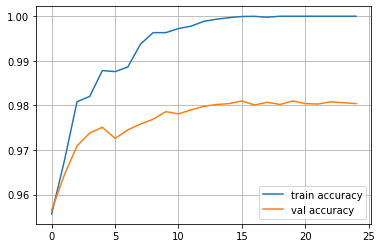

In [25]:
print("Epoch",24)
print("Train accuracy:",train_log[-1])
print("Val accuracy:",val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

Ploting 10 predictions from validation set

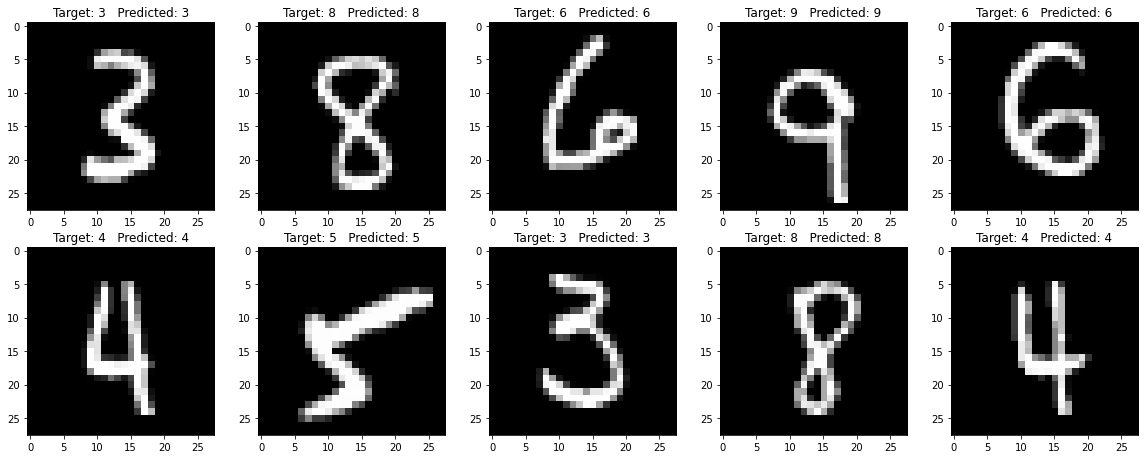

In [31]:
prediction = model.predict(X_val)
plot_predictions(X_val, y_val, prediction, n_plots=10, figsize=[20,20])
